# Technical exercise - Bilberry

❖ Your goal is to create the BEST two class classifier possible : Field & Road using only the available data. Note that we will evaluate your model on another dataset.
❖ You can use any Deep Learning framework (Note that we have a slight preference for
Tensorflow). Also keep in mind that the exercise will be reviewed under linux.
❖ Feel free to be creative but we want you to justify any of your choices (architecture, training parameters ...). A code description for the different choices you made is highly desirable. Moreover you should be able to talk about all these choices during a potential interview.
❖ Performance matters but creativity and justifications as well.


# Table of Contents

- [1 - Imports](#Imports)
- [2 - Loading the data](#Loading-the-data)
- [3 - Split the data - train 70%, validation 15%, test 15%](#Split-the-data---train70%-val15%-test15%)
- [4 - Build the model](#Build-the-model)
    - [4.1 - Create a sequential model with Keras](#1---Create-a-sequential-model)
    - [4.2 - Create a model with data augmentation](#2---Create-a-model-with-data-augmentation)
    - [4.3 - model without Transfer Learning - InceptionResNetV2](#3---model-without-transfer-learning---InceptionResNetV2)
    - [4.4 - model with Transfer Learning - InceptionResNetV2](#4---model-with-transfer-learning---InceptionResNetV2)
- [5 - Summary](#Summary)
- [6 - Save the model](#Save-the-model)
- [7 - Load the model - pretrained](#Load-the-model-pretrained)
- [8 - Little demonstration](#Predict-the-class-of-an-image)

# Imports

In [1]:
import gc
import glob
import os
import time
import warnings
from random import randrange


import cv2
import numpy as np
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import Dense, MaxPooling2D, Flatten, Conv2D, Dropout, BatchNormalization
from keras.models import Sequential
#from tensorflow.keras.utils import to_categorical
from keras.utils.np_utils import to_categorical  # convert to one-hot-encoding
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm_notebook

from tensorflow.keras.optimizers import Adam,RMSprop,SGD, Nadam

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # ignore tensorflow warnings
warnings.filterwarnings("ignore")

In [3]:
path_data = './data'
# /data is the folder where "fields" and "roads" are located

# Loading the data

In [4]:
def load_data(path, xdim=224, ydim=224):
    label_names = []
    X = []
    y = []
    count = 0
    directories = os.listdir(path)
    directories.sort()
    for dirname in tqdm_notebook(directories, desc="Loading images..."):
        if dirname == ".DS_Store": continue
        label_names.append(dirname)
        data_path = os.path.join(path + "/" + dirname, '*g')
        files = glob.glob(data_path)
        files.sort()
        for f1 in files:
            img = cv2.imread(f1, cv2.IMREAD_COLOR)
            img = cv2.resize(img, (int(xdim * 1), int(ydim * 1)))
            X.append(np.array(img))
            if dirname == "fields":
                y.append(1)
            elif dirname == "roads":
                y.append(0)
            count += 1
    X = np.array(X)
    y = np.array(y)
    print("\n ================= Summary of extraction ================= \n")
    print(count, ' images lues')
    print("\nX.shape = ", X.shape)
    print("y.shape = ", y.shape)
    print("Fields : y=1 \nRoads  : y=0")
    print("\n ================= End of summary ================= \n")
    gc.collect()
    return X, y, label_names

In [5]:
X, y, label_names = load_data(path_data)

Loading images...:   0%|          | 0/3 [00:00<?, ?it/s]


 ================= Summary of extraction ================= 

90  images lues

X.shape =  (90, 224, 224, 3)
y.shape =  (90,)
Fields : y=1 
Roads  : y=0

 ================= End of summary ================= 



In [6]:
X = X / 255.
# X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 3)
y = to_categorical(y)
print("\n")
print("--------------------------------------------------------------------------------\n")
print("\nX shape : {:19}   |   y shape : {}".format(str(X.shape), y.shape))
print("\n\n--------------------------------------------------------------------------------")
print("There is {} classes and {} images collected from the datasets.".format(y.shape[1], y.shape[0]))
print("\n--------------------------------------------------------------------------------\n")
# print("y : \n", y)



--------------------------------------------------------------------------------


X shape : (90, 224, 224, 3)     |   y shape : (90, 2)


--------------------------------------------------------------------------------
There is 2 classes and 90 images collected from the datasets.

--------------------------------------------------------------------------------



In [7]:
# function - onehot to labels
def oneHot_to_labels(onehot):
    for i in range(len(onehot)):
        if onehot[i] == 0:
            labeled = label_names[i]
    return labeled

num = randrange(y.shape[0])
print("\n\n--------------------------------------------------------------------------------")
print("n° {}\n".format(num))
print("One hot : {} ".format(y[num]))
print("\nLabeled : {} ".format(oneHot_to_labels(y[num])))



--------------------------------------------------------------------------------
n° 18

One hot : [0. 1.] 

Labeled : fields 




--------------------------------------------------------------------------------

                                   PLOT SOME IMAGES


--------------------------------------------------------------------------------


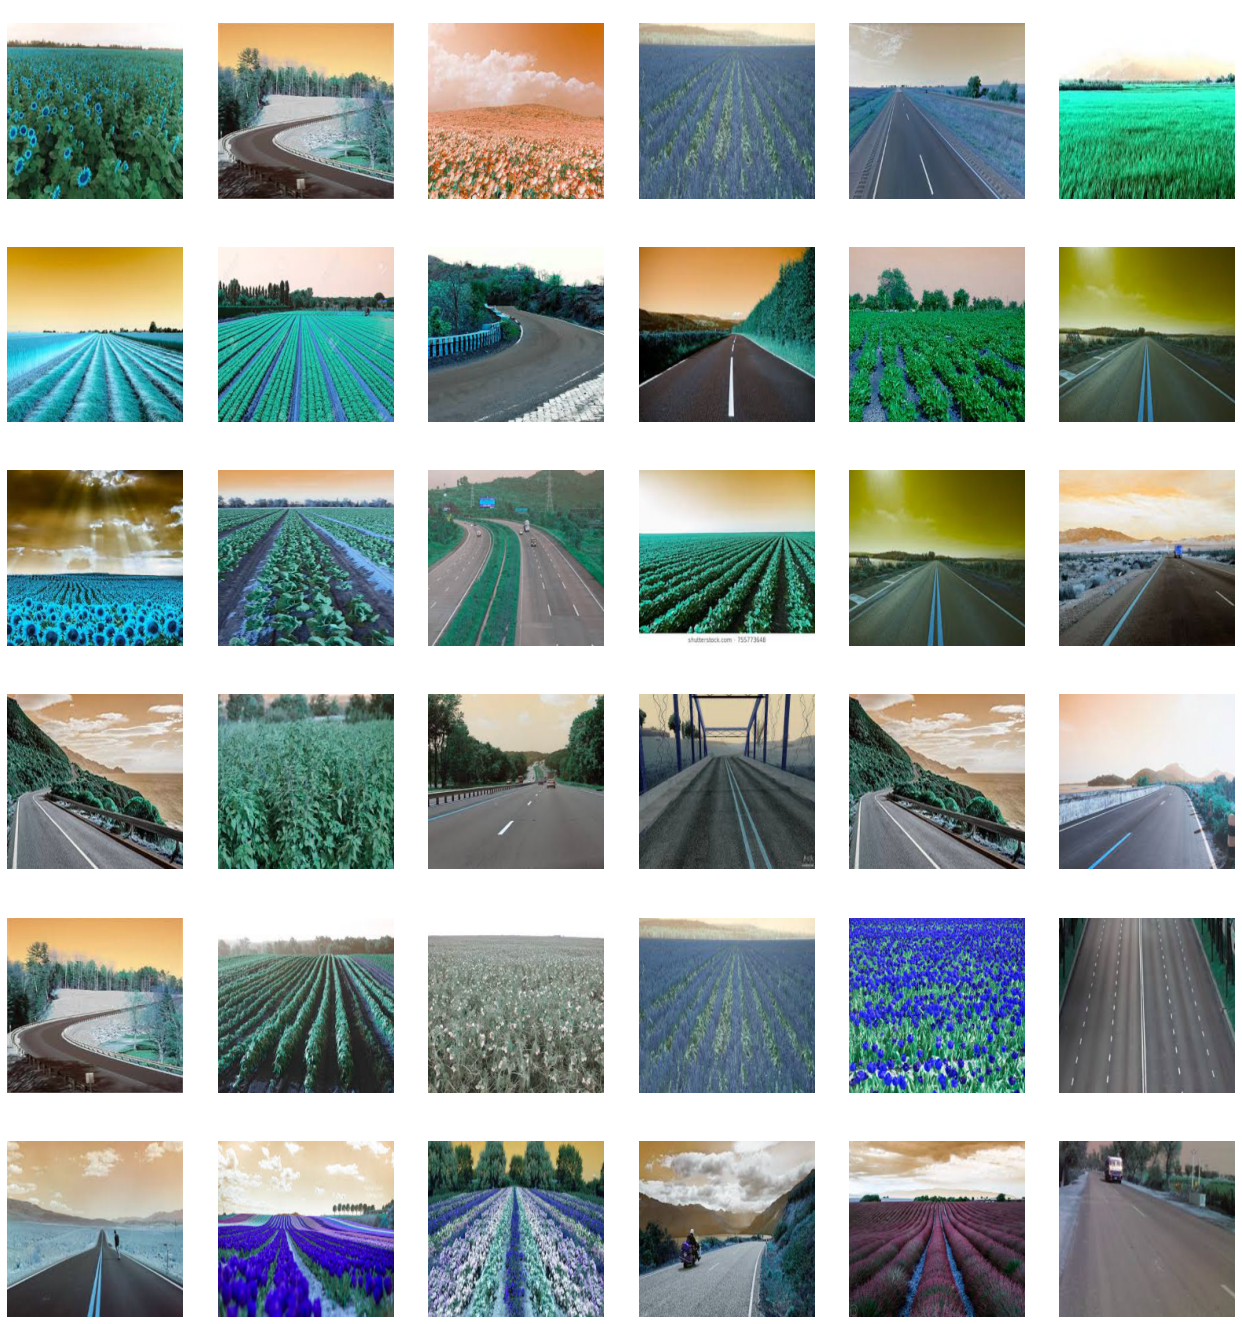

In [8]:
plt.figure(figsize=(22, 24))
print("\n")
print("--------------------------------------------------------------------------------\n")
print("                                   PLOT SOME IMAGES")
print("\n\n--------------------------------------------------------------------------------")

for i in range(36):
    ax = plt.subplot(6, 6, i + 1)
    r = randrange(y.shape[0])
    plt.imshow(X[r], cmap=plt.cm.colors.ListedColormap(['white', 'black']))
    # title_obj = plt.title("Class : {}".format(np.argmax(y[r])))
    title_obj = plt.title("Label : {}".format(oneHot_to_labels(y[r])))
    plt.setp(title_obj, color='white')
    plt.axis("off")

# Split the data - train70% val15% test15%

In [9]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print("\nSplitting data ...\n")
print("\n=============================== Splitting data =============================== \n\n")
print("X_train shape   : {:19}    |    y_train shape : {}\n".format(str(X_train.shape), y_train.shape))
print("------------------------------------------------------------------------------")
print("X_val shape     : {:19}    |    y_val shape   : {}\n".format(str(X_val.shape), y_val.shape))
print("------------------------------------------------------------------------------")
print("X_test shape    : {:19}    |    y_test shape  : {}\n".format(str(X_test.shape), y_test.shape))


Splitting data ...


=============================== Splitting data =============================== 


X_train shape   : (63, 224, 224, 3)      |    y_train shape : (63, 2)

------------------------------------------------------------------------------
X_val shape     : (13, 224, 224, 3)      |    y_val shape   : (13, 2)

------------------------------------------------------------------------------
X_test shape    : (14, 224, 224, 3)      |    y_test shape  : (14, 2)



In [10]:
# Count the number of images in each class in the training, validation, and test sets
def count_images(y, class_index):
    count = 0
    for line in y:
        if line[class_index] == 1:
            count += 1
    return count

print(count_images(y_test, 1))


10


# Build the model

From now on, i will divide in 4 parts :
    - 1 - Building a random model
    - 2 - Building a model using data augmentation
    - 3 - InceptionResNetV2 without transfer learning
    - 4 - InceptionResNetV2 using transfer learning

In [11]:
# Here are the parameters used to train :
batch_size = 16
epochs = 60
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.7,
                                            min_lr=0.00000000001)
early_stopping = EarlyStopping(monitor='val_accuracy',
                               min_delta=1e-3,
                               patience=15,
                               verbose=0,
                               restore_best_weights=True)

## 1 - Create a sequential model

In [12]:
# This is a model that I used for a project that I did in the past.
def create_model(name):
    model = Sequential(name=name)
    model.add(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Dropout(0.25))
    model.add(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Dropout(0.25))
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Dropout(0.25))
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    # model.compile(loss='categorical_crossentropy', optimizer=Nadam(learning_rate=0.001), metrics=['accuracy'])
    model.compile(loss='categorical_crossentropy', optimizer="nadam", metrics=['accuracy'])
    # Here I choose "nadam" because it was the best optimizer for this model. "Adam" doesn't work in my macbook M1.
    # I also tried "SGD" and "RMSprop" but they didn't work well.
    # To test I only did with 10 epochs and a learning rate of 0.001.
    return model

In [13]:
model = create_model(name="first-model")

model.summary()

Metal device set to: Apple M1
Model: "first-model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 16)      2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 16)      64        
_________________________________________________________________
max_pooling2d_1 (MaxPooli

### Train the model

In [14]:
start_time = time.time()
history_first_model = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val),
                    callbacks=[learning_rate_reduction])
first_model_training_time = time.time() - start_time
print("\n\n--- Training time : %.2f seconds ---" % first_model_training_time)

Epoch 1/60
4/4 [==============================] - 1s 138ms/step - loss: 7.3643 - accuracy: 0.4286 - val_loss: 0.7522 - val_accuracy: 0.3077
Epoch 2/60
4/4 [==============================] - 0s 93ms/step - loss: 0.5101 - accuracy: 0.9365 - val_loss: 0.6090 - val_accuracy: 0.6923
Epoch 3/60
4/4 [==============================] - 0s 93ms/step - loss: 0.3183 - accuracy: 0.9524 - val_loss: 0.6292 - val_accuracy: 0.6923
Epoch 4/60
4/4 [==============================] - 0s 91ms/step - loss: 0.0816 - accuracy: 0.9683 - val_loss: 0.8170 - val_accuracy: 0.6154

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
Epoch 5/60
4/4 [==============================] - 0s 93ms/step - loss: 0.1361 - accuracy: 0.9524 - val_loss: 0.9497 - val_accuracy: 0.6154
Epoch 6/60
4/4 [==============================] - 0s 91ms/step - loss: 0.0433 - accuracy: 0.9683 - val_loss: 1.2251 - val_accuracy: 0.6154

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0004900000232737511.
Epo

### Evaluate the model on the test set

In [15]:
score_first_model = model.evaluate(X_test, y_test, verbose=0)
print("\n ================= Evaluation : model ================= \n")
print("  Results : \n")
print("Loss  : %.2f" % (score_first_model[0]))
print("Score : %.2f%%" % (score_first_model[1] * 100))


 ================= Evaluation : model ================= 

  Results : 

Loss  : 8.68
Score : 28.57%


### plot the loss and accuracy curves for the training and validation sets

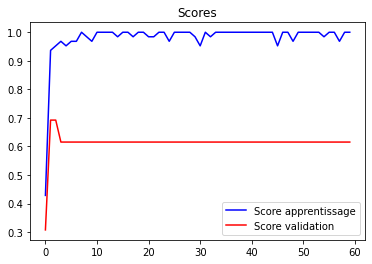

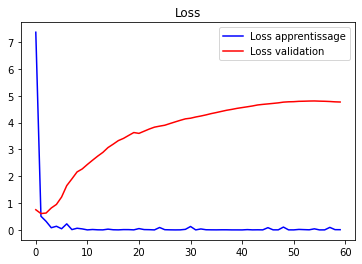

In [16]:
def plot_scores(train):
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()


def plot_loss(train):
    loss = train.history['loss']
    val_loss = train.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'b', label='Loss apprentissage')
    plt.plot(epochs, val_loss, 'r', label='Loss validation')
    plt.title('Loss')
    plt.legend()
    plt.show()


plot_scores(history_first_model)
plot_loss(history_first_model)

## 2 - Create a model with data augmentation

In [17]:
#I will use the same model as the first one, but i will add data augmentation
model = create_model(name="2nd-model-data-augmentation")
model.summary()

Model: "2nd-model-data-augmentation"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
batch_normalization_4 (Batch (None, 224, 224, 16)      64        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 112, 112, 16)      2320      
_________________________________________________________________
batch_normalization_5 (Batch (None, 112, 112, 16)      64        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56,

### Train the model with data augmentation

In [18]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    rescale=1. / 255,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest')

datagen.fit(X_train)


In [19]:
it_train = datagen.flow(X_train, y_train, batch_size=batch_size)
it_val = datagen.flow(X_val, y_val, batch_size=batch_size)
it_test = datagen.flow(X_test, y_test, batch_size=batch_size)

In [20]:
history_second_model = model.fit_generator(generator=it_train,
                              validation_data=(X_val, y_val),
                              steps_per_epoch=(len(X_train) // batch_size),
                              epochs=epochs,
                              callbacks=[learning_rate_reduction])
second_model_training_time = time.time() - start_time
print("\n\n--- Training time : %s2f seconds ---" % second_model_training_time)

Epoch 1/60
3/3 [==============================] - 1s 139ms/step - loss: 8.6158 - accuracy: 0.4468 - val_loss: 0.9928 - val_accuracy: 0.3846
Epoch 2/60
3/3 [==============================] - 0s 101ms/step - loss: 2.8336 - accuracy: 0.6383 - val_loss: 0.7869 - val_accuracy: 0.3846
Epoch 3/60
3/3 [==============================] - 0s 97ms/step - loss: 1.5344 - accuracy: 0.7917 - val_loss: 0.8010 - val_accuracy: 0.3846

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
Epoch 4/60
3/3 [==============================] - 0s 95ms/step - loss: 1.9432 - accuracy: 0.7234 - val_loss: 0.8457 - val_accuracy: 0.3846
Epoch 5/60
3/3 [==============================] - 0s 98ms/step - loss: 0.5944 - accuracy: 0.8085 - val_loss: 0.9337 - val_accuracy: 0.3846

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0004900000232737511.
Epoch 6/60
3/3 [==============================] - 0s 98ms/step - loss: 1.0064 - accuracy: 0.8511 - val_loss: 0.9698 - val_accuracy: 0.3846
Ep

### Evaluate the model on the test set

In [21]:
score_second_model = model.evaluate(X_test, y_test, verbose=0)
print("\n ================= Evaluation : model ================= \n")
print("  Results : \n")
print("Loss  : %.2f" % (score_second_model[0]))
print("Score : %.2f%%" % (score_second_model[1] * 100))


 ================= Evaluation : model ================= 

  Results : 

Loss  : 1.11
Score : 71.43%


### plot the loss and accuracy curves for the training and validation sets

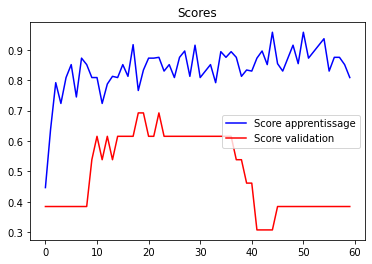

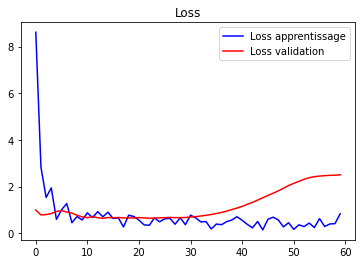

In [22]:
plot_scores(history_second_model)
plot_loss(history_second_model)

## 3 - model without transfer learning - InceptionResNetV2

In [23]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2

def create_model_withoutTL(name):
    base_model = InceptionResNetV2(weights=None, include_top=False, input_shape=(224, 224, 3))
    base_model.tbatch_sizenable = False
    model = Sequential(name=name)
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Nadam(learning_rate=0.001) , metrics=['accuracy'])
    return model

In [24]:
model = create_model_withoutTL(name="Inception-without-TL")

model.summary()

Model: "Inception-without-TL"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
flatten_2 (Flatten)          (None, 38400)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              39322624  
_________________________________________________________________
dropout_8 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)        

### Training the model ...

In [25]:
start_time = time.time()
history_model_withoutTL = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val),
                    callbacks=[learning_rate_reduction])
model_withoutTL_training_time = time.time() - start_time
print("\n\n--- Training time : %.2f seconds ---" % model_withoutTL_training_time)

Epoch 1/60
4/4 [==============================] - 23s 2s/step - loss: 19.6336 - accuracy: 0.4762 - val_loss: 0.7090 - val_accuracy: 0.3846
Epoch 2/60
4/4 [==============================] - 6s 1s/step - loss: 4.4853 - accuracy: 0.6032 - val_loss: 1.4523 - val_accuracy: 0.6154
Epoch 3/60
4/4 [==============================] - 6s 1s/step - loss: 2.6126 - accuracy: 0.6984 - val_loss: 1.4936 - val_accuracy: 0.6154
Epoch 4/60
4/4 [==============================] - 6s 1s/step - loss: 5.2648 - accuracy: 0.5873 - val_loss: 2.3421 - val_accuracy: 0.6154

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
Epoch 5/60
4/4 [==============================] - 6s 1s/step - loss: 1.5173 - accuracy: 0.8413 - val_loss: 1.7204 - val_accuracy: 0.6154
Epoch 6/60
4/4 [==============================] - 6s 1s/step - loss: 0.4917 - accuracy: 0.9048 - val_loss: 1.3770 - val_accuracy: 0.6154

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0004900000232737511.
Epoch 7/60
4/4

### Evaluate the model on the test set

In [26]:
score_withoutTL = model.evaluate(X_test, y_test, verbose=0)
print("\n ================= Evaluation : model ================= \n")
print("  Results : \n")
print("Loss  : %.2f" % (score_withoutTL[0]))
print("Score : %.2f%%" % (score_withoutTL[1] * 100))


 ================= Evaluation : model ================= 

  Results : 

Loss  : 11.12
Score : 28.57%


### Plot the loss and accuracy curves for training and validation

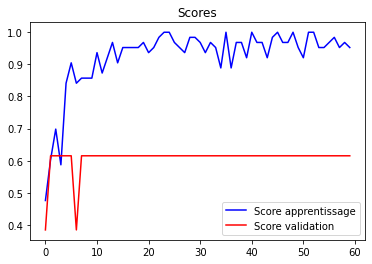

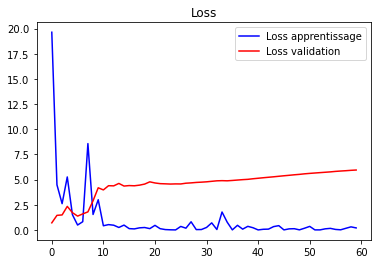

In [27]:
plot_scores(history_model_withoutTL)
plot_loss(history_model_withoutTL)

## 4 - model with transfer learning - InceptionResNetV2

In [28]:
def create_model_TL(name):
    base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.tbatch_sizenable = False
    model = Sequential(name=name)
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Nadam(learning_rate=0.001), metrics=['accuracy'])
    return model

In [29]:
model = create_model_TL(name="Inception-with-TL")
model.summary()

Model: "Inception-with-TL"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
flatten_3 (Flatten)          (None, 38400)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              39322624  
_________________________________________________________________
dropout_10 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)           

### Training the model ...

In [30]:
start_time = time.time()
history_model_TL = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val),
                    callbacks=[learning_rate_reduction])
inceptionTL_training_time = (time.time() - start_time)
print("\n\n--- Training time : %.2f seconds ---" % inceptionTL_training_time)

Epoch 1/60
4/4 [==============================] - 23s 2s/step - loss: 8.1756 - accuracy: 0.5238 - val_loss: 17.2700 - val_accuracy: 0.6154
Epoch 2/60
4/4 [==============================] - 6s 1s/step - loss: 5.9887 - accuracy: 0.5397 - val_loss: 2.7217 - val_accuracy: 0.6154
Epoch 3/60
4/4 [==============================] - 7s 2s/step - loss: 3.1639 - accuracy: 0.7778 - val_loss: 2.0721 - val_accuracy: 0.6923
Epoch 4/60
4/4 [==============================] - 6s 1s/step - loss: 1.1354 - accuracy: 0.9683 - val_loss: 1.4985 - val_accuracy: 0.6923
Epoch 5/60
4/4 [==============================] - 6s 1s/step - loss: 0.2434 - accuracy: 0.9365 - val_loss: 1.2970 - val_accuracy: 0.6923

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
Epoch 6/60
4/4 [==============================] - 6s 1s/step - loss: 2.1126 - accuracy: 0.9524 - val_loss: 1.3919 - val_accuracy: 0.6923
Epoch 7/60
4/4 [==============================] - 6s 1s/step - loss: 0.4581 - accuracy: 0.9683 

### Evaluate the model on the test set

In [31]:
score_withTL = model.evaluate(X_test, y_test, verbose=0)
print("\n ================= Evaluation : model ================= \n")
print("  Results : \n")
print("Loss  : %.2f" % (score_withTL[0]))
print("Score : %.2f%%" % (score_withTL[1] * 100))


 ================= Evaluation : model ================= 

  Results : 

Loss  : 0.10
Score : 92.86%


### Plot the loss and accuracy curves for training and validation

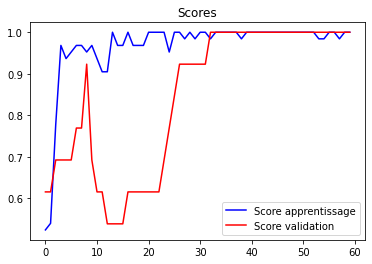

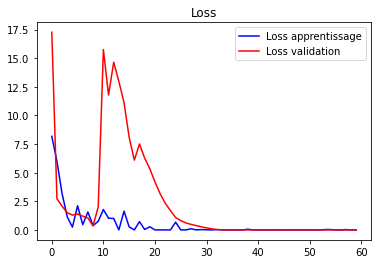

In [32]:
plot_scores(history_model_TL)
plot_loss(history_model_TL)

# Summary

In [33]:
models = ["first model", "second model", "InceptionResNetV2 without TL", "InceptionResNetV2 with TL"]
scores = [score_first_model, score_second_model, score_withoutTL, score_withTL]
training_times = [first_model_training_time, second_model_training_time, model_withoutTL_training_time, inceptionTL_training_time]

print("\n ==================== Summary ==================== \n")
print("Info : \n")
print(" Input-shape : (224, 224, 3)")
print(" Batch-size : %d" % batch_size)
print(" Epochs : %d" % epochs)
for i in range(len(models)):
    print("\n---------------------------------------------- ")
    print("Evaluation : {} \n".format(models[i]))
    print("  Results : \n")
    print("Loss  : %.2f" % (scores[i][0]))
    print("Score : %.2f%%" % (scores[i][1] * 100))
    print("\n --- Training time : %.2f seconds ---" % (training_times[i]))



 ==================== Summary ==================== 

Info : 

 Input-shape : (224, 224, 3)
 Batch-size : 16
 Epochs : 60

---------------------------------------------- 
Evaluation : first model 

  Results : 

Loss  : 8.68
Score : 28.57%

 --- Training time : 22.96 seconds ---

---------------------------------------------- 
Evaluation : second model 

  Results : 

Loss  : 1.11
Score : 71.43%

 --- Training time : 46.24 seconds ---

---------------------------------------------- 
Evaluation : InceptionResNetV2 without TL 

  Results : 

Loss  : 11.12
Score : 28.57%

 --- Training time : 366.55 seconds ---

---------------------------------------------- 
Evaluation : InceptionResNetV2 with TL 

  Results : 

Loss  : 0.10
Score : 92.86%

 --- Training time : 356.90 seconds ---


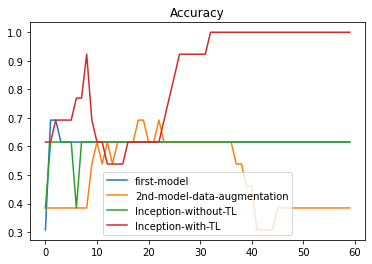

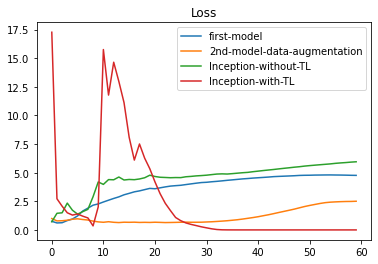

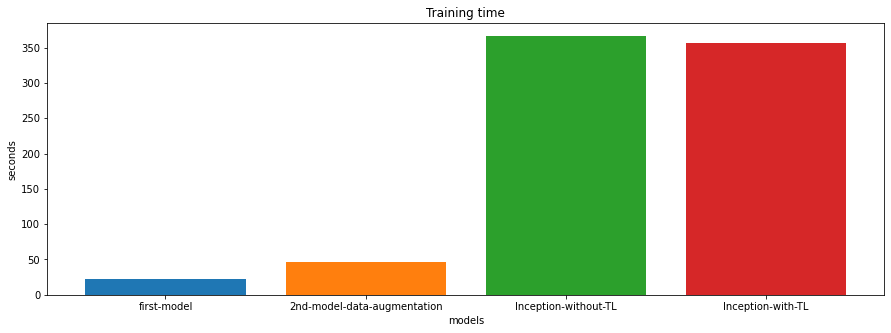

In [34]:
histories = [history_first_model, history_second_model, history_model_withoutTL, history_model_TL]

def plot_all_scores(array_of_history):
    for history in array_of_history:
        # accuracy = history.history['accuracy']
        val_accuracy = history.history['val_accuracy']
        n_epochs = range(len(val_accuracy))
        # plt.plot(epochs, accuracy, 'b', label=str(history.model.name) + ' accuracy')
        plt.plot(n_epochs, val_accuracy, label=str(history.model.name))
    plt.title('Accuracy')
    plt.legend()
    plt.show()


def plot_all_losses(array_of_history):
    for history in array_of_history:
        # loss = history.history['loss']
        val_loss = history.history['val_loss']
        n_epochs = range(len(val_loss))
        # plt.plot(epochs, loss, 'b', label='str(history.model.name) + ' loss')
        plt.plot(n_epochs, val_loss, label=str(history.model.name))
    plt.title('Loss')
    plt.legend()
    plt.show()

def plot_training_time(array_of_training_time):
    i = 0
    fig = plt.figure(figsize = (15, 5))
    for time in array_of_training_time:
        plt.bar(str(histories[i].model.name), time)
        i+=1
    plt.title('Training time')
    plt.ylabel('seconds')
    plt.xlabel('models')
    #plt.legend()
    plt.show()

plot_all_scores(histories)
plot_all_losses(histories)
plot_training_time(training_times)

# Save the model

From now on, i will save the model using transfer learning

# Load the model - pretrained

In [35]:
from keras.models import model_from_json

architecture_path = "saved_models/inception_resnet_v2.json"
weight_path = "saved_models/inception_resnet_v2.h5"

json_file = open(architecture_path, 'r')
loaded_model_json = json_file.read()
json_file.close()

model_loaded = model_from_json(loaded_model_json)
model_loaded.load_weights(weight_path)
model_loaded.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
print("------------------------------ Model loaded ------------------------------")
print(model_loaded.summary())

------------------------------ Model loaded ------------------------------
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
flatten_3 (Flatten)          (None, 38400)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              39322624  
_________________________________________________________________
dropout_10 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_____________________________________________

# Predict the class of an image

In [36]:
y_pred = model_loaded.predict(X_temp)

In [37]:
# function - one hot prediction -> label
def pred_to_label(onehot):
    new_onehot=[]
    for i in range(len(onehot)):
        if onehot[i] == max(onehot):
            new_onehot.append(1)
        else:
            new_onehot.append(0)
    #new_onehot va être égale à un hardmax onehot exemple : [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
    labeled = oneHot_to_labels(new_onehot)
    return labeled

num = 7
print("N°", num)
print("One hot (Prediction) : \n {} ".format(y_pred[num]))
print("\nLabeled : {} ".format(pred_to_label(y_pred[num])))

N° 7
One hot (Prediction) : 
 [1. 0.] 

Labeled : roads 


 ================= Demonstration ================= 



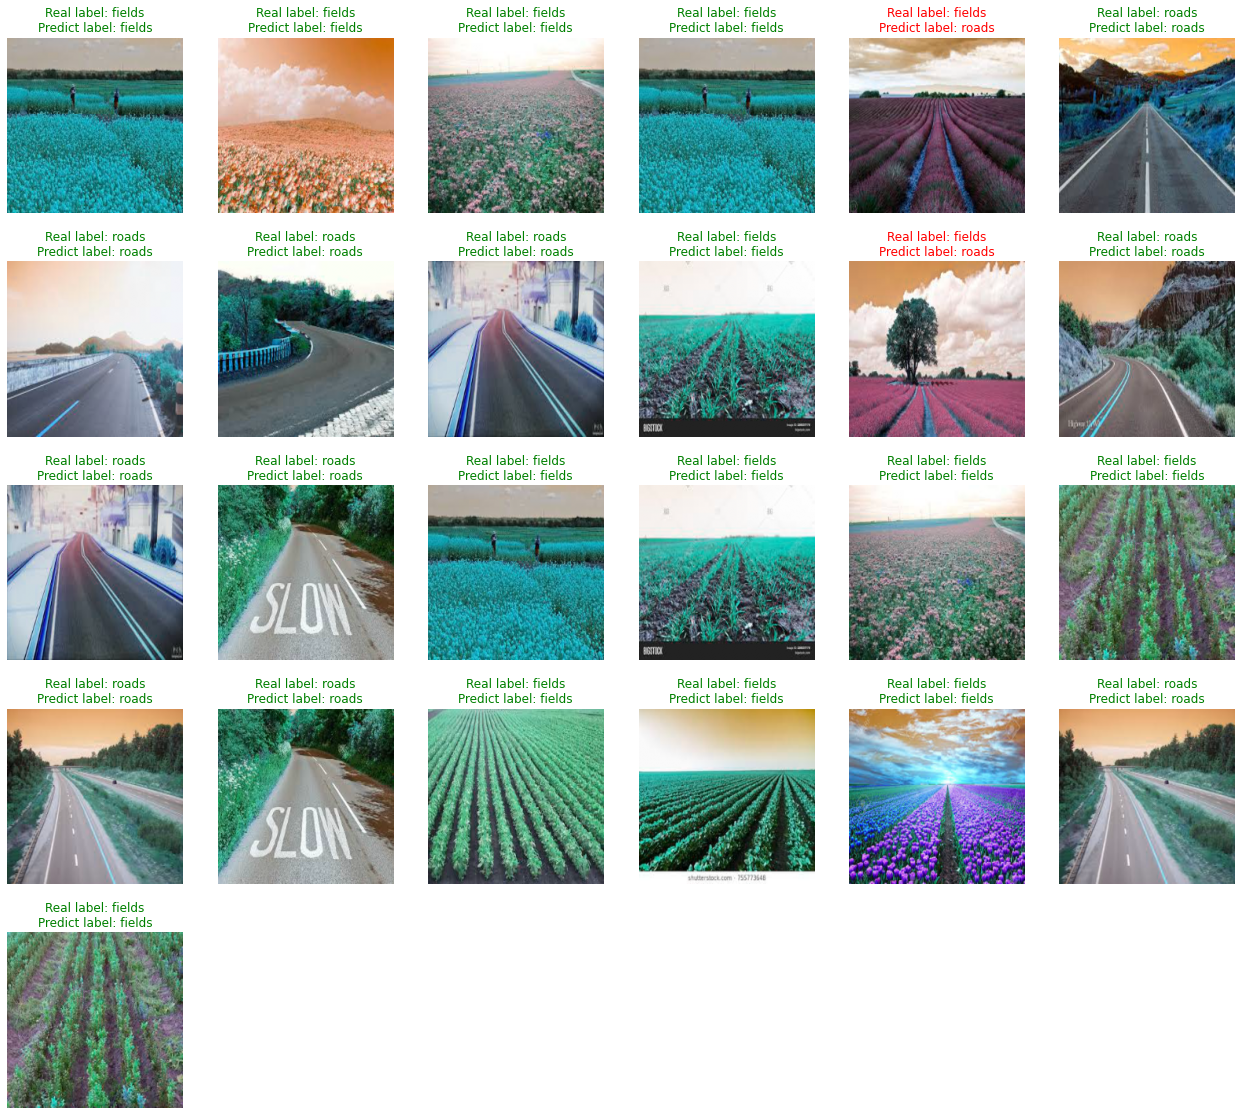

In [38]:
plt.figure(figsize=(22, 24))

print(" ================= Demonstration ================= \n")

for i in range(25):
    ax = plt.subplot(6, 6, i + 1)
    index = np.random.randint(0, len(X_temp))
    plt.imshow(X_temp[index], cmap=plt.cm.binary)
    # title_obj = plt.title("Real class: {}\nPredict class: {}".format(np.argmax(y_temp[i]), y_pred[i].argmax()))
    title_obj = plt.title("Real label: {}\nPredict label: {}".format(oneHot_to_labels(y_temp[index]), pred_to_label(y_pred[index])))
    if np.argmax(y_pred[index]) == np.argmax(y_temp[index]):
        plt.setp(title_obj, color='green')
    else:
        plt.setp(title_obj, color='red')
    plt.axis("off")